In [1]:
# libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
import time

#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef

#Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

#Neural Network
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Lambda, Layer, ReLU
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D,Concatenate

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path6 = 'Epileptic Seizure Recognition.csv'
figures_path = './figures'

In [3]:
if not os.path.exists(figures_path):
    os.makedirs(figures_path)
if not os.path.exists(figures_path+"/6FP"):
    os.makedirs(figures_path+"/6FP")


In [4]:
Data = pd.read_csv(data_path6)

In [5]:
Data=Data.drop(["Unnamed"],axis=1)

In [6]:
Labels = Data['y'].values
Features = Data.drop(['y'],axis=1).values


print('Features shape:', Features.shape)
print('Labels shape:', Labels.shape)


Features shape: (11500, 178)
Labels shape: (11500,)


In [7]:
for i in range(len(Labels)):
  if Labels[i]==2 or Labels[i]==3 or Labels[i]==4 or Labels[i]==5:
    Labels[i]=0
  else:
    Labels[i]=1



In [8]:
Labels

array([0, 1, 0, ..., 0, 0, 0])

In [9]:
LabelDataFrame=pd.DataFrame(Labels)

In [10]:
#Write function for class-centric metrics
# Classification report
def CR_viz():
    def Class_report(model,classes):
        visualizer = ClassificationReport(model, classes=classes, support=True)
        train_start_time = time.time()
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        print(f'Train runtime: {time.time()-train_start_time}')
        test_start_time = time.time()
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        print(f'Test runtime: {time.time()-test_start_time}')
        return visualizer.poof()
    for name, classifier in zip(names, classifiers):
        fig, ax = plt.subplots(nrows=1, ncols=1 )
        Class_report(classifier,classes)
        #fig.savefig(figures_path+"/"+str(len(classes))+"FP/"+name+"_CR.pdf")

#Class Prediction Error
def CPE_viz():
    def CPE(model,classes):
        visualizer = ClassPredictionError(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name, classifier in zip(names, classifiers):
        fig, ax = plt.subplots(nrows=1, ncols=1 )
        CPE(classifier,classes)
        #fig.savefig(figures_path+"/"+str(len(classes))+"FP/"+name+"_CPE.pdf")

#Confusion matrix
def CM_viz():
    def CM(model,classes):
        visualizer = ConfusionMatrix(model, classes=classes, percent=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name, classifier in zip(names, classifiers):
        fig, ax = plt.subplots(nrows=1, ncols=1 )
        CM(classifier,classes)
        #fig.savefig(figures_path+"/"+str(len(classes))+"FP/"+name+"_CM.pdf")

#ROC-AUC
def ROC_viz():
    def ROC(model,classes):
        visualizer = ROCAUC(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name, classifier in zip(names, classifiers):
        fig, ax = plt.subplots(nrows=1, ncols=1 )
        ROC(classifier,classes)
        #fig.savefig(figures_path+"/"+str(len(classes))+"FP/"+name+"_ROC.pdf")

#Precision Recall Curve
def PRC_viz():
    def PRC(model,classes):
        visualizer = PrecisionRecallCurve(model,classes=classes, per_class=True, iso_f1_curves=False,
    fill_area=False, micro=False)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name, classifier in zip(names, classifiers):
        fig, ax = plt.subplots(nrows=1, ncols=1 )
        PRC(classifier,classes)
        #fig.savefig(figures_path+"/"+str(len(classes))+"FP/"+name+"_PRC.pdf")

In [11]:
LabelDataFrame[0].value_counts()

0    9200
1    2300
Name: 0, dtype: int64

In [12]:
# Write function for aggregate metrics
def classifier_metrics():
    def metrics(model):
        #     model=model_name()
        model.fit(X_train, y_train)  # Fit the visualizer and the model
        y_pred = model.predict(X_test)
       # model.save('modeloEpilepsia.h5')
        try:
            y_prob = model.predict_proba(X_test)
            log_metric = log_loss(y_test,y_prob)
        except:
            y_prob = "Not probablistic"
            log_metric = 0
        else:
            y_pred = model.predict(X_test)

        acc_score=accuracy_score(y_test,y_pred)
        c_k_s=cohen_kappa_score(y_test,y_pred)
        zero_met=zero_one_loss(y_test,y_pred)
        hl=hamming_loss(y_test,y_pred)
        mc=matthews_corrcoef(y_test,y_pred)
        print('accuracy_score: {0:.4f}'.format(acc_score))
        print('cohen_kappa_score: {0:.4f}'.format(c_k_s))
        print('log_loss: {0:.4f}'.format(log_metric))
        print('zero_one_loss: {0:.4f}'.format(zero_met))
        print('hemming_loss: {0:.4f}'.format(hl))
        print('matthews_corrcoef: {0:.4f}'.format(mc))
    for name in classifiers:
        print (str(name))
        metrics(name)
        print()
        print ("---------------------------------------------------------------------------------")

In [13]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=45)

X_sm, y_sm = sm.fit_resample(Features, Labels)

print(f'''Shape of X before SMOTE: {Features.shape}
Shape of X after SMOTE: {X_sm.shape}''')

Shape of X before SMOTE: (11500, 178)
Shape of X after SMOTE: (18400, 178)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Train data shape: (14720, 178)
Train labels shape: (14720,)
Test data shape: (3680, 178)
Test labels shape: (3680,)


In [15]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
X_train.shape

(14720, 178)

In [17]:
X_train=np.expand_dims(X_train, axis=-1)
X_test=np.expand_dims(X_test, axis=-1)

In [18]:
X_train.shape

(14720, 178, 1)

In [19]:
#classes
classes = [0, 1]

In [20]:
# select classifiers

## HIPERPARAMETROS
#classifiers=[
#ExtraTreesClassifier(n_estimators=220, max_depth=None, min_samples_split=3, random_state=18), #Definitivo
#svm.SVC(C=3000000, gamma=0.1), #Definitivo
#RandomForestClassifier(n_estimators=600,criterion='entropy',random_state=18), #Definitivo
#GradientBoostingClassifier(n_estimators=2048, learning_rate=0.03, max_depth=10, random_state=10) #Definitivo
#]

#names=['ET', 'SVM', 'RF','GB']

In [21]:
#deploy visualization A
#visualization =[CR_viz(),CPE_viz(),CM_viz(),ROC_viz(),PRC_viz()]

In [22]:
#Deploy aggregate metrics
#classifier_metrics()

In [23]:


class KerasBatchClassifier(KerasClassifier, BaseEstimator):
    def __init__(self, model, **kwargs):
        super().__init__(model)
        self.fit_kwargs = kwargs
        self._estimator_type = 'classifier'

    def fit(self, x, y, *args, **kwargs):
        y = np.array(y)
        if len(y.shape) == 2 and y.shape[1] > 1:
          self.classes_ = np.arange(y.shape[1])
        elif (len(y.shape) == 2 and y.shape[1] == 1) or len(y.shape) == 1:
          self.classes_ = np.unique(y)
          y = np.searchsorted(self.classes_, y)
        else:
          raise ValueError('Invalid shape for y: ' + str(y.shape))
        self.n_classes_ = len(self.classes_)
        return super(KerasClassifier, self).fit(x, y, **self.fit_kwargs)


# RED NEURONAL
def FullyConnected():



  inputs = Input(shape=(X_train.shape[1],1), name="input_1")


  Layer_1=tf.keras.layers.Conv1D(32,3,activation="selu",padding="same")(inputs)
  Layer_1=tf.keras.layers.Conv1D(32,3,activation="selu",padding="same")(Layer_1)
  Pool_1=tf.keras.layers.MaxPool1D(2)(Layer_1)
  Pool_1=tf.keras.layers.Dropout(rate=0.5)(Pool_1)


  Layer_1=tf.keras.layers.Conv1D(64,3,activation="selu",padding="same")(Pool_1)
  Layer_1=tf.keras.layers.Conv1D(64,3,activation="selu",padding="same")(Layer_1)
  Pool_1=tf.keras.layers.MaxPool1D(2)(Layer_1)
  Pool_1=tf.keras.layers.Dropout(rate=0.5)(Pool_1)

  Layer_1=tf.keras.layers.Conv1D(128,3,activation="selu",padding="same")(Pool_1)
  Layer_1=tf.keras.layers.Conv1D(128,3,activation="selu",padding="same")(Layer_1)
  Layer_1=tf.keras.layers.Conv1D(128,3,activation="selu",padding="same")(Layer_1)
  Pool_1=tf.keras.layers.MaxPool1D(2)(Layer_1)
  Pool_1=tf.keras.layers.Dropout(rate=0.5)(Pool_1)

  Layer_1=tf.keras.layers.Conv1D(256,3,activation="selu",padding="same")(Pool_1)
  Layer_1=tf.keras.layers.Conv1D(256,3,activation="selu",padding="same")(Layer_1)
  Layer_1=tf.keras.layers.Conv1D(256,3,activation="selu",padding="same")(Layer_1)
  Pool_1=tf.keras.layers.MaxPool1D(2)(Layer_1)
  Pool_1=tf.keras.layers.Dropout(rate=0.5)(Pool_1)

  Layer_1=tf.keras.layers.Conv1D(512,3,activation="selu",padding="same")(Pool_1)
  Layer_1=tf.keras.layers.Conv1D(512,3,activation="selu",padding="same")(Layer_1)
  Layer_1=tf.keras.layers.Conv1D(512,3,activation="selu",padding="same")(Layer_1)

  Pool_1=tf.keras.layers.MaxPool1D(2)(Layer_1)
  Pool_1=tf.keras.layers.Dropout(rate=0.5)(Pool_1)

  Layer_1=tf.keras.layers.Conv1D(512,3,activation="selu",padding="same")(Pool_1)
  Layer_1=tf.keras.layers.Conv1D(512,3,activation="selu",padding="same")(Layer_1)
  Layer_1=tf.keras.layers.Conv1D(512,3,activation="selu",padding="same")(Layer_1)


  Pool_1=tf.keras.layers.MaxPool1D(2)(Layer_1)
  Pool_1=tf.keras.layers.Dropout(rate=0.5)(Pool_1)


  Flat=tf.keras.layers.GlobalMaxPooling1D()(Pool_1)

  layers = Dense(1024,activation="selu")(Flat)
  layers = BatchNormalization()(layers)

  layers = Dense(512,activation="selu")(layers)
  layers = BatchNormalization()(layers)

  layers = Dense(256,activation="selu")(layers)
  layers = BatchNormalization()(layers)

  layers = Dense(128,activation="selu")(layers)
  layers = BatchNormalization()(layers)

  layers = Dense(64,activation="selu")(layers)
  layers = BatchNormalization()(layers)

  layers = Dense(32,activation="selu")(layers)
  layers = BatchNormalization()(layers)

  layers = Dense(16,activation="selu")(layers)
  layers = BatchNormalization()(layers)


  predictions = Dense(len(classes), activation="softmax", name="output_1")(layers)


  model = Model(inputs = inputs, outputs=predictions)
  optimizer=Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
                loss=sparse_categorical_crossentropy,
                metrics=['accuracy'])
  return model

In [24]:
classifiers=[KerasBatchClassifier(FullyConnected, epochs=500, batch_size=128, verbose=0)]
names = ['FNN']

KerasBatchClassifier(build_fn=<function FullyConnected at 0x7f30389cd900>)
115/115 [==============================] - 0s 4ms/step
accuracy_score: 0.9978
cohen_kappa_score: 0.9957
log_loss: 0.0054
zero_one_loss: 0.0022
hemming_loss: 0.0022
matthews_corrcoef: 0.9957

---------------------------------------------------------------------------------
Train runtime: 0.4623074531555176
115/115 [==============================] - 1s 7ms/step
Test runtime: 2.9781112670898438


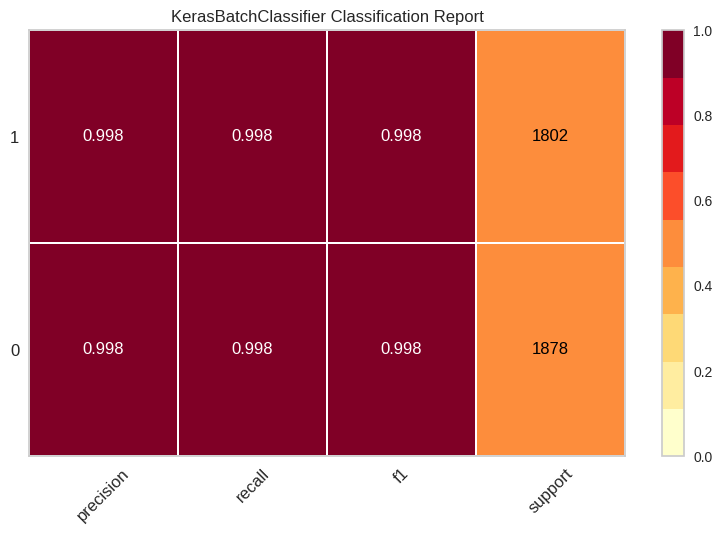

115/115 [==============================] - 1s 5ms/step - loss: 0.0054 - accuracy: 0.9978


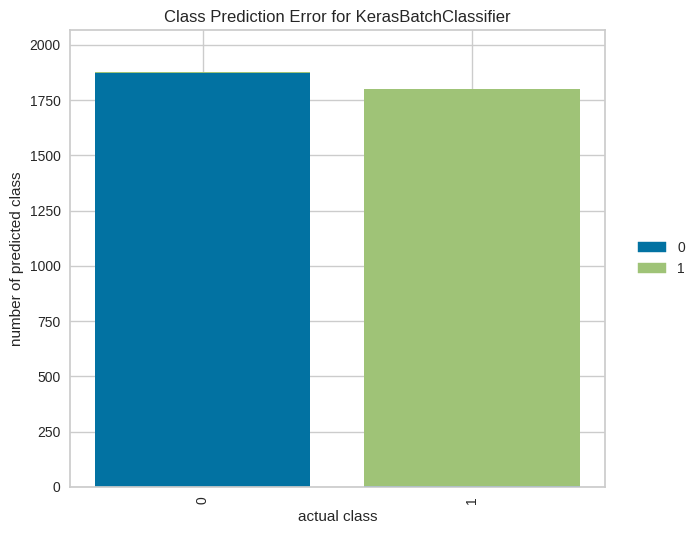

115/115 [==============================] - 1s 4ms/step


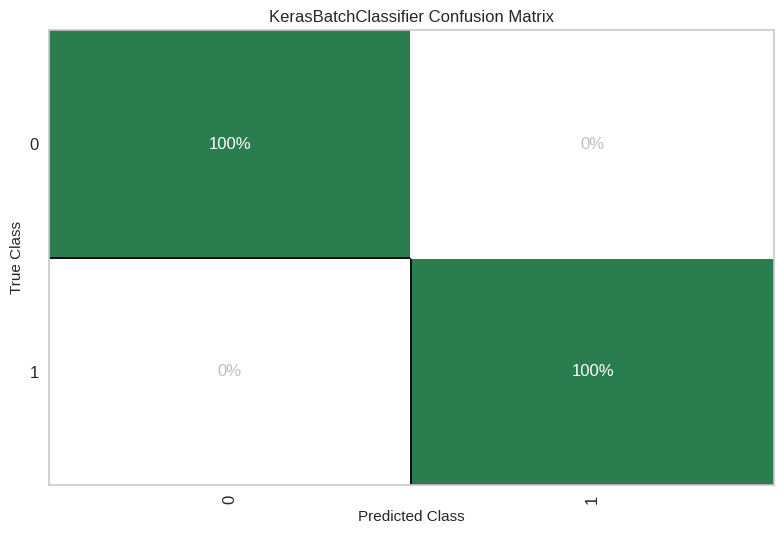

115/115 [==============================] - 0s 4ms/step


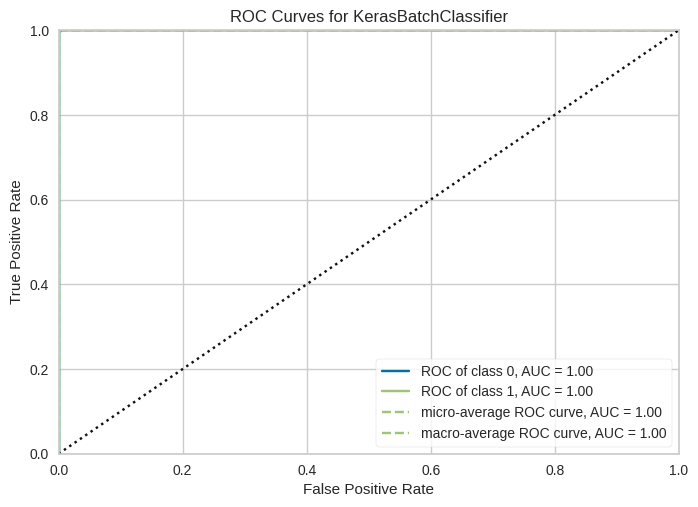

In [25]:
classifier_metrics()
visualization =[CR_viz(),CPE_viz(),CM_viz(),ROC_viz()]